In [1]:
!gdown --id '1XNBXdKHNnbhmiXXqbJNqh2l0nLSLuNve' --output hw1.zip
!unzip -q hw1.zip

Downloading...
From: https://drive.google.com/uc?id=1XNBXdKHNnbhmiXXqbJNqh2l0nLSLuNve
To: /content/hw1.zip
100% 678M/678M [00:04<00:00, 146MB/s]


In [2]:
import os
import shutil
from operator import itemgetter 
import numpy as np
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from PIL import Image
from torch.utils.data import ConcatDataset, DataLoader, Subset
from torchvision.datasets import DatasetFolder
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
from torchvision.datasets import ImageFolder
from tqdm.auto import tqdm
import torchvision.models as models

In [3]:
os.chdir('/content')
os.makedirs("train")
os.makedirs("test")
os.makedirs("validation")

WORK_PATH = os.path.join('train')
shutil.move("training_images.zip", WORK_PATH)

os.chdir('/content/train')
!unzip -q training_images.zip
os.remove('training_images.zip')

dataset_indices = list(range(3000))
np.random.shuffle(dataset_indices)
val_split_index = int(np.floor(0.08 * 3000))
train_idx, val_idx = dataset_indices[val_split_index:], dataset_indices[:val_split_index]
valid_plt = itemgetter(*val_idx)(os.listdir('/content/train'))

os.chdir('/content/train')
for i in valid_plt:
  shutil.move(i, "/content/validation")

os.chdir('/content')
f = open("classes.txt", "r")
os.chdir('/content/train')
for line in f.readlines():
  os.mkdir("{}".format(line.rstrip("\n")))

os.chdir('/content')
f = open("classes.txt", "r")
os.chdir('/content/validation')
for line in f.readlines():
  os.mkdir("{}".format(line.rstrip("\n")))

os.chdir('/content')
f = open("training_labels.txt", "r")
os.chdir('/content/train')
for line in f.readlines():
    str1 = line.split(' ')[0]
    str2 = line.split(' ')[1].rstrip("\n")
    WORK_PATH = os.path.join(str2)
    if os.path.isfile(str1):
      shutil.move(str1, WORK_PATH)

os.chdir('/content')
f = open("training_labels.txt", "r")
os.chdir('/content/validation')
for line in f.readlines():
    str1 = line.split(' ')[0]
    str2 = line.split(' ')[1].rstrip("\n")
    WORK_PATH = os.path.join(str2)
    if os.path.isfile(str1):
      shutil.move(str1, WORK_PATH)

for d in os.listdir("/content/validation"):
  path = os.path.join("/content/validation",d)
  if len(os.listdir(path)) == 0:
    os.chdir(os.path.join("/content/train",d))
    shutil.move(os.listdir(os.path.join("/content/train",d))[0], path)

os.chdir("/content/test")
os.makedirs("0")
os.chdir('/content')
shutil.move("testing_images.zip", '/content/test/0')
os.chdir('/content/test/0')
!unzip -q testing_images.zip
os.remove('testing_images.zip')

In [11]:
train_tfm = transforms.Compose([
    transforms.Resize((224, 224)),
    #transforms.RandomResizedCrop((224, 224)),
    #transforms.RandomRotation(30, resample=Image.BICUBIC, expand=False),
    #transforms.ColorJitter(contrast=(0.5, 1.5), saturation=(0.5, 1.5)),
    #transforms.RandomAffine(0, shear=10, scale=(0.8,1.2)),
    transforms.RandomHorizontalFlip(p=0.9),
    #transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_tfm = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

batch_size = 64

#train_set = DatasetFolder("/content/train", loader=lambda x: Image.open(x), extensions="jpg", transform=train_tfm)
#valid_set = DatasetFolder("/content/validation", loader=lambda x: Image.open(x), extensions="jpg", transform=test_tfm)
#test_set = DatasetFolder("/content/test", loader=lambda x: Image.open(x), extensions="jpg", transform=test_tfm)

train_set = ImageFolder("/content/train", train_tfm)
valid_set = ImageFolder("/content/validation", train_tfm)
test_set = ImageFolder("/content/test", test_tfm)

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True)
valid_loader = DataLoader(valid_set, batch_size=batch_size, shuffle=False, drop_last=True, num_workers=0, pin_memory=True)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

classes = {v: k for k, v in train_set.class_to_idx.items()}

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:1231: UserWarning: Argument resample is deprecated and will be removed since v0.10.0. Please, use interpolation instead
  "Argument resample is deprecated and will be removed since v0.10.0. Please, use interpolation instead"


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


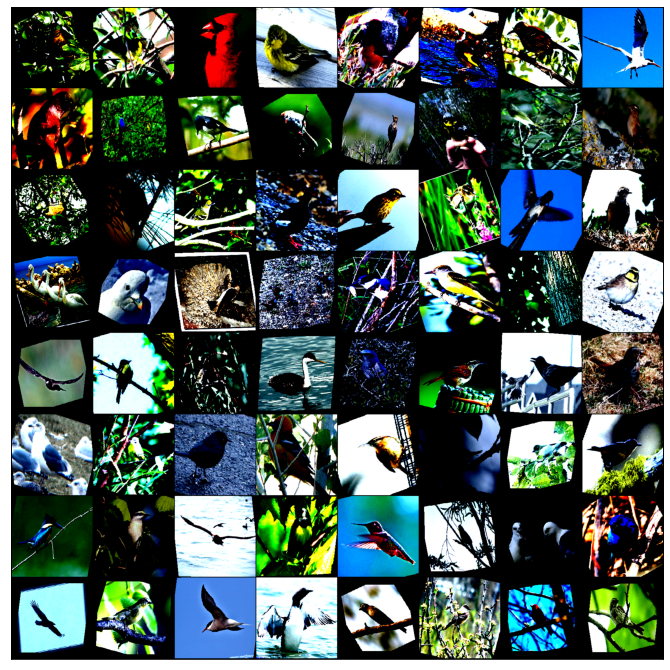

In [12]:
def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images[:64], nrow=8).permute(1, 2, 0))
        break

show_batch(train_loader)
show_batch(valid_loader)

In [13]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model = models.resnet50(pretrained = True).to(device)
for param in model.parameters():
    param.requires_grad = False  
model.fc = nn.Sequential(
               nn.Linear(2048, 512),
               nn.ReLU(inplace=True),
               nn.Linear(512, 200)).to(device)
model.device = device

criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.fc.parameters(), lr=0.0003, weight_decay=1e-5)
#optimizer = torch.optim.SGD(model.parameters(), lr=0.0003, momentum=0.9, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[30, 60], gamma=0.5)

n_epochs = 90

In [1]:
for epoch in range(n_epochs):

    model.train()
    #show_batch(train_loader)
    #show_batch(test_loader)

    train_loss = []
    train_accs = []

    for batch in tqdm(train_loader):

        imgs, labels = batch
        
        logits = model(imgs.to(device))
        loss = criterion(logits, labels.to(device))
        optimizer.zero_grad()
        loss.backward()
        grad_norm = nn.utils.clip_grad_norm_(model.parameters(), max_norm=10)
        optimizer.step()
        acc = (logits.argmax(dim=-1) == labels.to(device)).float().mean()
        train_loss.append(loss.item())
        train_accs.append(acc)

    train_loss = sum(train_loss) / len(train_loss)
    train_acc = sum(train_accs) / len(train_accs)

    scheduler.step()

    print(f"[ Train | {epoch + 1:03d}/{n_epochs:03d} ] loss = {train_loss:.5f}, acc = {train_acc:.5f}")
    
    model.eval()

    valid_loss = []
    valid_accs = []

    for batch in tqdm(valid_loader):

        imgs, labels = batch
        with torch.no_grad():
          logits = model(imgs.to(device))
        loss = criterion(logits, labels.to(device))
        acc = (logits.argmax(dim=-1) == labels.to(device)).float().mean()
        valid_loss.append(loss.item())
        valid_accs.append(acc)
    valid_loss = sum(valid_loss) / len(valid_loss)
    valid_acc = sum(valid_accs) / len(valid_accs)
    print(f"[ Valid | {epoch + 1:03d}/{n_epochs:03d} ] loss = {valid_loss:.5f}, acc = {valid_acc:.5f}")

NameError: ignored

In [ ]:
model.eval()
predictions = []

for batch in tqdm(test_loader):
    imgs, labels = batch
    with torch.no_grad():
        logits = model(imgs.to(device))
    predictions.extend(logits.argmax(dim=-1).cpu().numpy().tolist())

  0%|          | 0/48 [00:00<?, ?it/s]

In [ ]:
os.chdir("/content/test/0")
test = os.listdir()
num_test = []
for i in test:
  str1 = i.split(".")[0]
  n = int(str1)
  num_test.append(n)

num_test.sort()
os.chdir("/content")

with open('testing_img_order.txt') as f:
     test_images = [x.strip() for x in f.readlines()]  # all the testing images

submission = []
for img in test_images:  # image order is important to your result
    
    n = int(img.split(".")[0])
    i = num_test.index(n)
    #str1 = predictions[i]
    predicted_class = classes[predictions[i]]  # the predicted category
    #predicted_class = predicted_class.rstrip("\n")
    submission.append([img, predicted_class])
    
np.savetxt('answer.txt', submission, fmt='%s')

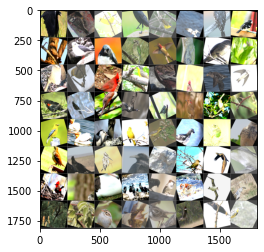

tensor([107, 189, 160,  28,  19, 142,  80,  56,  91,  83, 159,  17,  66, 154,
         39, 152,  90, 174,  16,  19,  33,  34,   7, 134,   9, 106,  32,  24,
        158,  35, 154, 199, 176, 100,  93, 181, 160,   5, 122, 103, 148, 106,
         80, 106, 197, 185,  24, 178,  41,  98,   1,  22, 117, 118,   1,  58,
        162, 192, 116,  21, 121,  91,  29,  87])
108.White_necked_Raven 108.White_necked_Raven
190.Red_cockaded_Woodpecker 190.Red_cockaded_Woodpecker
161.Blue_winged_Warbler 161.Blue_winged_Warbler
029.American_Crow 049.Boat_tailed_Grackle
020.Yellow_breasted_Chat 200.Common_Yellowthroat
143.Caspian_Tern 143.Caspian_Tern
081.Pied_Kingfisher 081.Pied_Kingfisher
057.Rose_breasted_Grosbeak 057.Rose_breasted_Grosbeak
092.Nighthawk 190.Red_cockaded_Woodpecker
084.Red_legged_Kittiwake 084.Red_legged_Kittiwake
160.Black_throated_Blue_Warbler 160.Black_throated_Blue_Warbler
018.Spotted_Catbird 018.Spotted_Catbird
067.Anna_Hummingbird 067.Anna_Hummingbird
155.Warbling_Vireo 148.Green_tai

In [ ]:
dataiter = iter(train_loader)
images, labels = dataiter.next()

import torchvision

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
# print images
imshow(torchvision.utils.make_grid(images))
print(labels)
outputs = model(images.to(device))
_, predicted = torch.max(outputs, 1)
                        
for j in range(64):
  print(classes[int(labels[j])], classes[int(predicted[j])])